# AIDI 1003, Machine Learning Frameworks
# Project 3 – German Credit Dataset

**Context**: The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. It is difficult to understand the original dataset due to its complicated system of categories and symbols. Thus, several columns are simply ignored, because they are not important, or their descriptions are obscure. The selected attributes are:

    • Age (numeric)
    • Sex (text: male, female)
    • Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
    • Housing (text: own, rent, or free)
    • Saving accounts (text - little, moderate, quite rich, rich)
    • Checking account (numeric, in DM - Deutsch Mark)
    • Credit amount (numeric, in DM)
    • Duration (numeric, in month)
    • Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
    • Risk (Target value - Good or Bad Risk)
    
**Dataset Source**: https://georgiancollege-my.sharepoint.com/:x:/g/personal/archit_garg_georgiancollege_ca/EZ4fIquX871Dg-sYjmNhIOUB2HJlHI-KXqb0kQazWRO-Jg?e=hOXpZd

**Task**: Goal of this project is to cluster the customers and classify whether an applicant is considered a
Good or a Bad credit risk for 1000 loan applicants

**Implementation**:
- Perform EDA and any data cleaning if necessary.
- Perform one hot encoding for categorical variables
- Visualize the histograms of numerical features. Do you observe skewness in the data? If yes apply the log transformation. Check the histograms again to see if data has been normalized.
- Apply Feature Scaling
- Choose only the numerical features for clustering
- Apply elbow method to find best number of clusters. Plot the graph.
- Choose optimum number of clusters and visualize it using PCA
- Implement KFOLD CV and use any classifier of your choosing and report the evaluation metrics

**Submission Instructions**: Please just submit one jupyter notebook containing all the code and make use of markdown cells to include the comments, answers, reasoning, analysis, etc.

**Note: Name of your file should be your “Project3-id_Firstname_Lastname.ipynb”**


In [1]:
# coding=utf-8
import os
import math
import time
import joblib
import random
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import category_encoders as ce
from time import time
from xgboost import *
from scipy.stats import normaltest, linregress
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.ensemble import *
from sklearn.datasets import load_digits, make_hastie_10_2, load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# %matplotlib
# %matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 2000)

# 1. Data Preparation

In [2]:
df = pd.read_excel('./german_credit_data.xlsx')

## 1.1. EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [33]:
df.nunique()

Age               53
Sex                2
Job                4
Housing            3
Credit amount    921
Duration          33
Purpose            8
Risk               2
dtype: int64

In [5]:
df.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  Duration              Purpose  Risk
0   67    male    2     own             NaN           little           1169         6             radio/TV  good
1   22  female    2     own          little         moderate           5951        48             radio/TV   bad
2   49    male    1     own          little              NaN           2096        12            education  good
3   45    male    2    free          little           little           7882        42  furniture/equipment  good
4   53    male    2    free          little           little           4870        24                  car   bad

Age                 False
Sex                 False
Job                 False
Housing             False
Saving accounts      True
Checking account     True
Credit amount       False
Duration            False
Purpose             False
Risk                False
dtype: bool


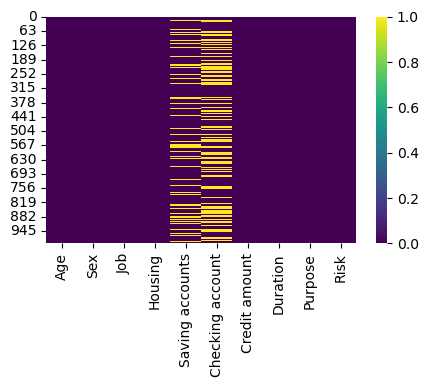

In [6]:
def null_data_visualization(f):
    print(f.isnull().any())
    plt.figure(figsize=(f.shape[1]/2, 3), dpi=100)
    sns.heatmap(f.isnull(), cmap="viridis")
null_data_visualization(df)

## 1.2. handle NaN

In [7]:
tmp = df[((df['Saving accounts'].isnull()) | (df['Checking account'].isnull()))]
rate = tmp.shape[0]*1.0/df.shape[0]
print("There are %.2f%% row data contains at least one Null Value features." % (rate*100))

There are 47.80% row data contains at least one Null Value features.


In [8]:
df = df.drop(['Saving accounts', 'Checking account'], axis=1)

In [9]:
# tmp = df[((df['Saving accounts'].isnull()) | (df['Checking account'].isnull()))]
# tmp.index
# df = df.drop(tmp.index, axis=0)
# df = df.reset_index(drop=True, inplace=False)

Age              False
Sex              False
Job              False
Housing          False
Credit amount    False
Duration         False
Purpose          False
Risk             False
dtype: bool


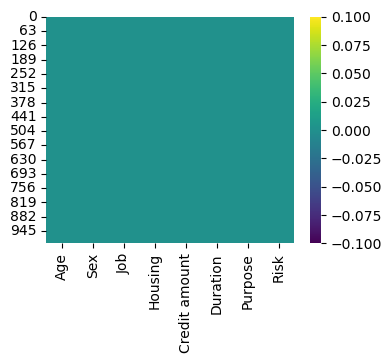

In [10]:
null_data_visualization(df)

## 2. one-hot encoding

In [11]:
encoder = ce.OneHotEncoder(cols=['Sex', 'Housing', 'Purpose'])
en_df = encoder.fit_transform(df)
# X_test = encoder.transform(X_test)
en_df

Age  Sex_1  Sex_2  Job  Housing_1  Housing_2  Housing_3  Credit amount  Duration  Purpose_1  Purpose_2  Purpose_3  Purpose_4  Purpose_5  Purpose_6  Purpose_7  Purpose_8  Risk
0     67      1      0    2          1          0          0           1169         6          1          0          0          0          0          0          0          0  good
1     22      0      1    2          1          0          0           5951        48          1          0          0          0          0          0          0          0   bad
2     49      1      0    1          1          0          0           2096        12          0          1          0          0          0          0          0          0  good
3     45      1      0    2          0          1          0           7882        42          0          0          1          0          0          0          0          0  good
4     53      1      0    2          0          1          0           4870        24          0          0          0          1          0          0          0          0   bad
..   ...    ...    ...  ...        ...        ...        ...            ...       ...        ...        ...        ...        ...        ...        ...        ...        ...   ...
995   31      0      1    1          1          0          0           1736        12          0          0          1          0          0          0          0          0  good
996   40      1      0    3          1          0          0           3857        30          0          0          0          1          0          0          0          0  good
997   38      1      0    2          1          0          0            804        12          1          0          0          0          0          0          0          0  good
998   23      1      0    2          0          1          0           1845        45          1          0          0          0          0          0          0          0   bad
999   27      1      0    2          1          0          0           4576        45          0          0          0          1          0          0          0          0  good

[1000 rows x 18 columns]

# 3. Visualize the histograms of numerical features. Do you observe skewness in the data? If yes apply the log transformation. Check the histograms again to see if data has been normalized.

In [12]:
class Foo:
    def __init__(self):
        self.df0 = pd.read_excel('./german_credit_data.xlsx')
        self.df = self.df0.copy()

        self.cols_categorical = ['Sex', 'Housing', 'Purpose']
        self.cols_numerical = ['Age', 'Job', 'Credit amount', 'Duration']
        self.cols_numerical_skewing = ['Age', 'Credit amount', 'Duration']
        self.cols_drop_off = ['Saving accounts', 'Checking account']
        self.col_y = 'Risk'

        # clean rows with null values
        self.df = self.df0.drop(self.cols_drop_off, axis=1)
        # tmp = self.df[((self.df['Saving accounts'].isnull()) | (self.df['Checking account'].isnull()))]
        # self.df = self.df.drop(tmp.index, axis=0)
        # self.df = self.df.reset_index(drop=True, inplace=False)
        self.X = self.df.drop([self.col_y], axis=1)
        self.__label_encoding(self.col_y)
        self.y = self.df[self.col_y]

    def __null_value_visualization(self):
        print(self.df.isnull().any())
        plt.figure(figsize=(self.df.shape[1] / 2, 3), dpi=100)
        sns.heatmap(self.df.isnull(), cmap="viridis")

    def feature_encoding(self):
        encoder = ce.OneHotEncoder(cols=self.cols_categorical)
        self.df = encoder.fit_transform(self.df)
        pass

    def onehot_encoding(self, x_train, x_test):
        categorical_data = [var for var in x_train.columns if x_train[var].dtype == 'O']

        encoder = ce.OneHotEncoder(cols=categorical_data)
        x_train = encoder.fit_transform(x_train)
        x_test = encoder.transform(x_test)

        scaler = RobustScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        return x_train, x_test

    def feature_scaling(self, plot=False):
        for col in self.df.columns:
            if self.df[col].dtype != 'O':
                self.scaling(self.df, col, action=None, plot=plot)
                self.scaling(self.df, col, action='log', plot=plot)
                self.scaling(self.df, col, action='minmax', plot=plot)
        # for col in self.cols_numerical_skewing:
        #     self.scaling(self.df, col, plot=plot)
        #     self.scaling(self.df, col, action='log', plot=plot)
        # for col in self.cols_numerical:
        #     self.scaling(self.df, col, action='minmax', plot=plot)
        # scaler = RobustScaler()
        # en_df = scaler.fit_transform(en_df)
        # # X_test = scaler.transform(X_test)
        # en_df
        pass

    def check_category(self):
        for _, col in enumerate(self.df.columns):
            print("Column Name:", col)
            print("Categorical display:")
            print(pd.value_counts(self.df[col]))
            print('-' * 100)

    def check_null(self):
        print(self.df.isnull().values.any())
        plt.figure(figsize=(8, 3), dpi=100)
        sns.heatmap(self.df.isnull(), cmap="viridis")

    def __label_encoding(self, c):
        self.df[c] = LabelEncoder().fit_transform(self.df[c])
        pass

    def label_encoding(self):
        # print("label encoding:")
        # print(self.df.head())
        for col in self.df.columns:
            if self.df[col].dtype == 'O':
                self.__label_encoding(col)
                # print("label encoding:%s\n%s" % (col, self.df.head()))
        pass

    @staticmethod
    def scaling(f, c, action=None, plot=False):
        tmp = f[[c]].copy()
        if action == 'log':
            tmp = np.log(tmp + 1)
            color = 'r'
        elif action == 'minmax':
            tmp = MinMaxScaler().fit_transform(tmp)
            color = 'g'
        elif action == 'standard':
            tmp = StandardScaler().fit_transform(tmp)
            color = 'b'
        else:
            color = 'k'

        if plot:
            g = sns.displot(tmp, kde=True, color=color)
            g.fig.set_figwidth(7)
            g.fig.set_figheight(2)
            plt.title("\"%s\" scaling:%s, (min:%.2f, max:%.2f)" % (c, action, tmp.min(), tmp.max()))
            plt.show()
        f[c] = tmp
        return f

    @staticmethod
    def search_cv(model, params, fold, verbose=0):
        return RandomizedSearchCV(model, params, cv=fold, verbose=verbose, return_train_score=True, )
        # return RandomizedSearchCV(model, params, cv=fold, verbose=0,
        #                           scoring=scoring, refit=list(scoring.items())[0][0], return_train_score=True, )

    def train_LR(self, x, y, random_state=0, verbose=0):
        model = LogisticRegression()
        params = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4]
        }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "LR", clf

    def train_DT(self, x, y, random_state=0, verbose=0):
        model = DecisionTreeClassifier()
        params = {
            'max_depth': [2, 3, 5, 10, 20],
            'min_samples_leaf': [5, 10, 20, 50, 100],
            'criterion': ["gini", "entropy"]
        }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "DT", clf

    def train_NB(self, x, y, random_state=0, verbose=0):
        model = GaussianNB()
        params = {
            'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
        }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "NB", clf

    def train_RF(self, x, y, random_state=0, verbose=0):
        model = RandomForestClassifier()
        params = {
            'bootstrap': [True, False],
            'max_depth': [2, 4, 8, 16, 32],
            'max_features': ['auto', 'sqrt', 'log2'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [10, 20, 50, 100, 200],
            'criterion': ['gini', 'entropy']
        }
        # scoring = {
        #     "Accuracy": make_scorer(accuracy_score),
        #     "mean_absolute_error": make_scorer(mean_absolute_error),
        #     "mean_squared_error": make_scorer(mean_squared_error),
        #     "r2_score": make_scorer(r2_score),
        # }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "RF", clf

    def train_XGB(self, x, y, random_state=0, verbose=0):
        model = XGBClassifier(eval_metric='logloss')
        params = {
            "learning_rate": [0.001, 0.01, 0.1, 1],
            "max_depth": [2,4,6,8,10],
            "min_child_weight": range(1, 10),
            "gamma": np.arange(0, 0.7, 0.2),
            "colsample_bytree": np.arange(0.1, 1.1, 0.1),
            "n_estimators": [10,20,50,100,200,500]
        }
        k_fold = StratifiedKFold(5, shuffle=True, random_state=random_state)
        clf = self.search_cv(model, params, k_fold, verbose=verbose)
        clf.fit(x, y)
        return "XGB", clf

foo = Foo()
foo.feature_encoding()


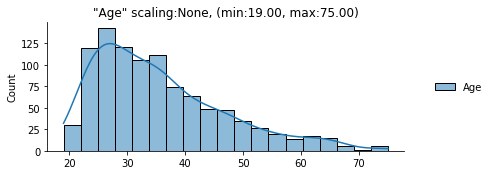

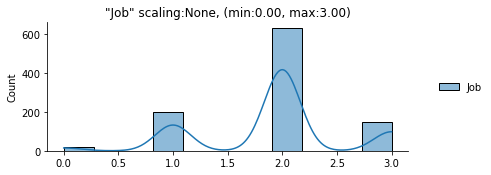

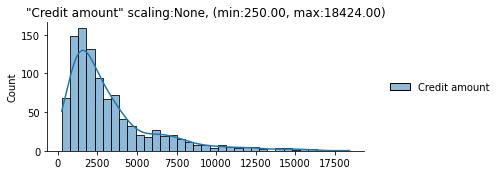

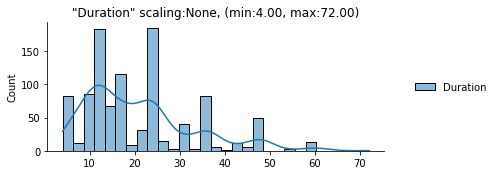

In [13]:
for col in foo.cols_numerical:
    foo.scaling(foo.df, col, action=None, plot=True)

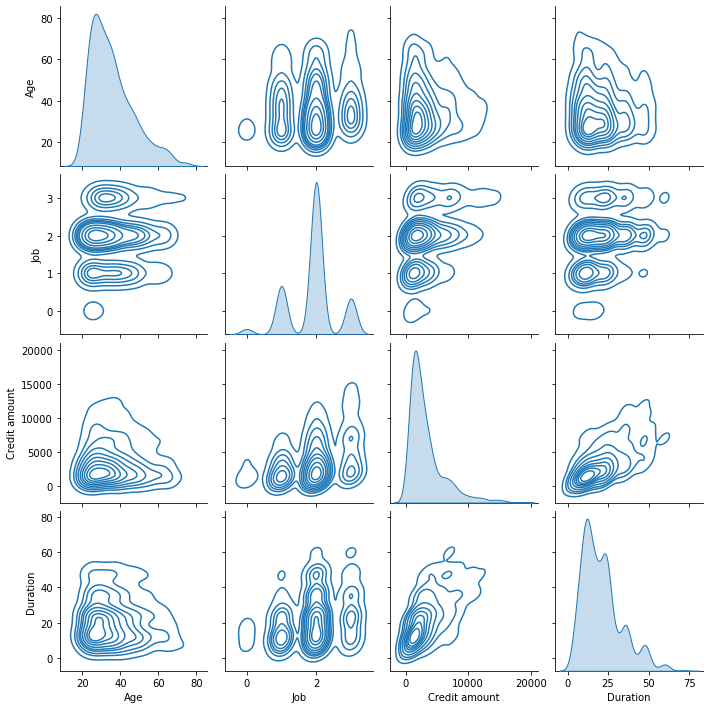

In [14]:
sns.pairplot(foo.df[foo.cols_numerical], kind="kde")

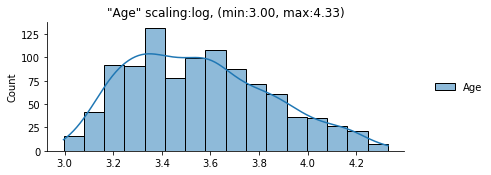

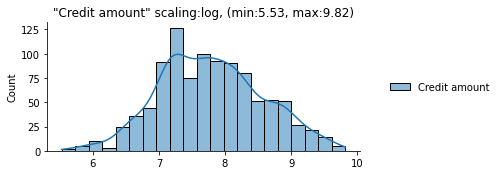

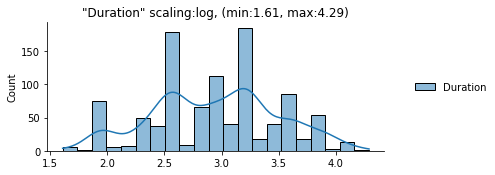

In [15]:
for col in foo.cols_numerical_skewing:
    foo.scaling(foo.df, col, action='log', plot=True)

# 4. Apply Feature Scaling


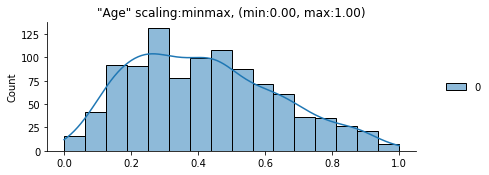

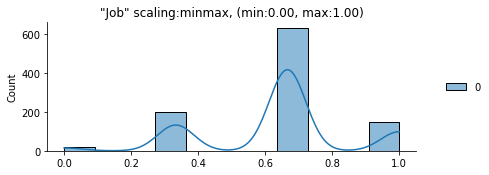

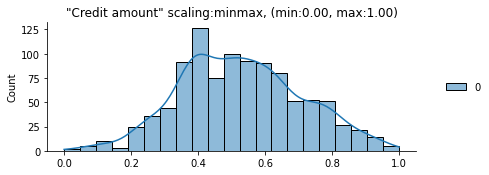

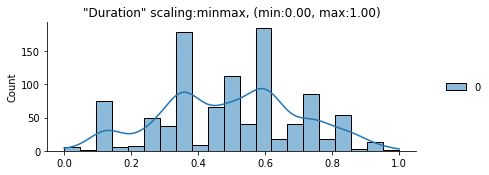

In [16]:
for col in foo.cols_numerical:
    foo.scaling(foo.df, col, action='minmax', plot=True)

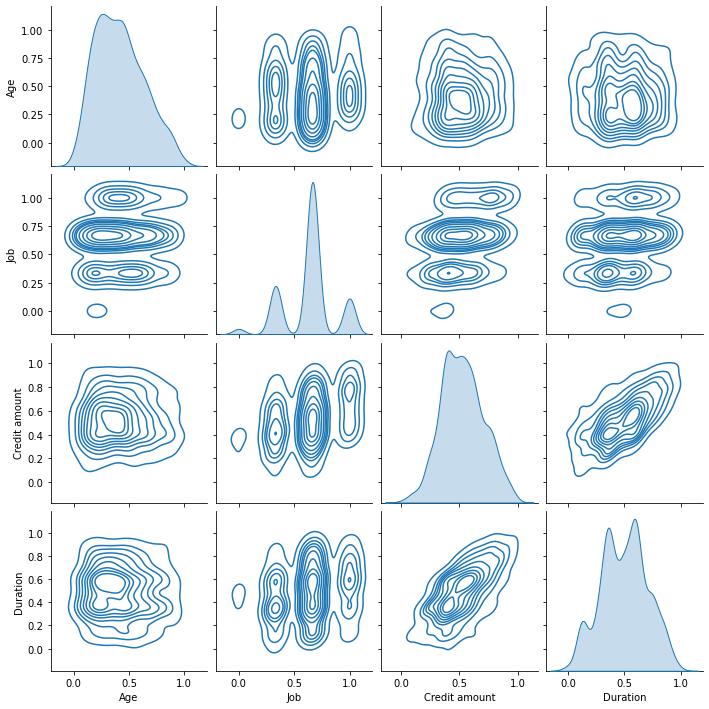

In [17]:
sns.pairplot(foo.df[foo.cols_numerical], kind="kde")

# 5. Choose only the numerical features for clustering

In [18]:
foo = Foo()
# foo.label_encoding()
# # foo.feature_encoding()
foo.feature_scaling(plot=False)
foo.X = foo.df[foo.cols_numerical]
foo.X

Age       Job  Credit amount  Duration
0    0.916685  0.792481       0.358311  0.125502
1    0.104691  0.792481       0.736970  0.851311
2    0.686360  0.500000       0.494135  0.356398
3    0.623901  0.792481       0.802375  0.802590
4    0.744008  0.792481       0.690315  0.600308
..        ...       ...            ...       ...
995  0.352062  0.500000       0.450293  0.356398
996  0.537707  1.000000       0.636044  0.680543
997  0.500246  0.792481       0.271272  0.356398
998  0.136570  0.792481       0.464460  0.827745
999  0.252039  0.792481       0.675824  0.827745

[1000 rows x 4 columns]

## 5.1. remove outliers for distance sensitive classification algorithm

In [19]:
import random
from sklearn.ensemble import IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans

def plot3d(ax, x1, x2, c1):
    ax.scatter3D(x1[:, 0], x1[:, 1], x1[:, 2], c=c1, cmap=plt.cm.Set1, edgecolor="k", s=40, alpha=.5, )
    ax.scatter3D(x2[:, 0], x2[:, 1], x2[:, 2], color='g', marker='x', s=40, alpha=.9, )
    ax.set_title("Visualizations on the first three PCA components")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

def outlier_removal(x, col_y, labels, protected_labels=np.array([]), outliers_fraction=0.01, plot=False):
    r = random.randint(1, 10000)
    if plot:
        print("random_state=%d" % r)
    clf = IsolationForest(random_state=r, max_samples=0.99, bootstrap=False, n_estimators=250, contamination=outliers_fraction)
    tmpdf = x.copy(deep=True)
    tmpdf['result'] = clf.fit_predict(tmpdf) # _predict(tmpdf)
    tmpdf.loc[(tmpdf['result'] == -1) & (tmpdf[col_y].isin(protected_labels)), 'result'] = 1

    if plot:
        f = np.mean(clf.score_samples(x))
        print("\nscorer_f : %.6f, rand_seed: %d" % (f, r))
        px = PCA().fit_transform(tmpdf)
        indices_norm = tmpdf[tmpdf['result'] == 1].index
        indices_iso = tmpdf[tmpdf['result'] == -1].index
        x1 = np.delete(px, indices_iso, axis=0)
        x2 = np.delete(px, indices_norm, axis=0)
        c1 = np.delete(labels, indices_iso)
        
        fig = plt.figure(figsize=(18, 6), dpi=100)
        gs = GridSpec(1, 3, figure=fig)
        ax1 = fig.add_subplot(gs[0, 0], projection='3d', elev=0, azim=0)
        ax2 = fig.add_subplot(gs[0, 1], projection='3d', elev=45, azim=45)
        ax3 = fig.add_subplot(gs[0, 2], projection='3d', elev=90, azim=90)
        
        plot3d(ax1, x1, x2, c1)
        plot3d(ax2, x1, x2, c1)
        plot3d(ax3, x1, x2, c1)

        plt.show()
    return tmpdf.drop(tmpdf[tmpdf['result'] == -1].index, axis=0).drop(['result'], axis=1).reset_index(drop=True)


random_state=7838

scorer_f : -0.465544, rand_seed: 7838


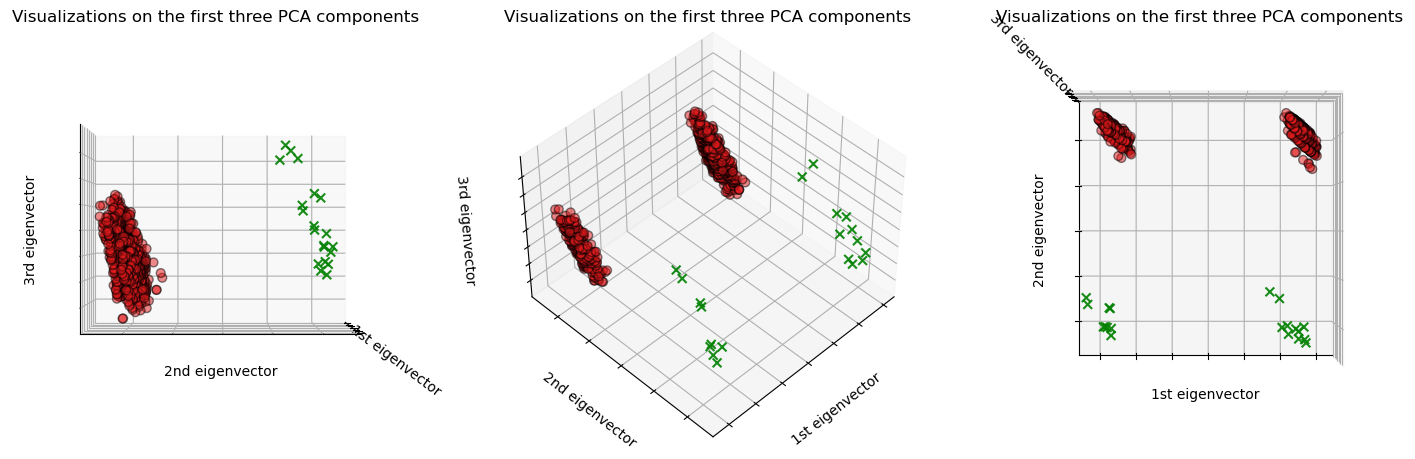

Age       Job  Credit amount  Duration  Risk
0    0.916685  0.792481       0.358311  0.125502     1
1    0.104691  0.792481       0.736970  0.851311     0
2    0.686360  0.500000       0.494135  0.356398     1
3    0.623901  0.792481       0.802375  0.802590     1
4    0.744008  0.792481       0.690315  0.600308     0
..        ...       ...            ...       ...   ...
975  0.352062  0.500000       0.450293  0.356398     1
976  0.537707  1.000000       0.636044  0.680543     1
977  0.500246  0.792481       0.271272  0.356398     1
978  0.136570  0.792481       0.464460  0.827745     0
979  0.252039  0.792481       0.675824  0.827745     1

[980 rows x 5 columns]

In [20]:
df_stage1 = foo.X.copy()
df_stage1['Risk'] = foo.y
c = [1] * foo.X.shape[0]
df_stage1 = outlier_removal(df_stage1, 'Risk', c, protected_labels=np.array([]), outliers_fraction=0.02, plot=True)
df_stage1 = df_stage1.reset_index(drop=True, inplace=False)
df_stage1

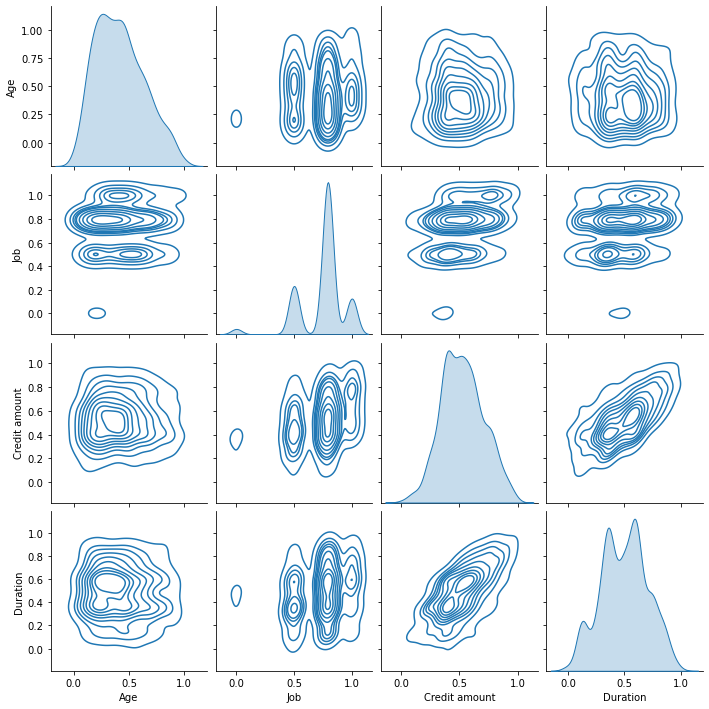

In [21]:
# pairplot after outlier removal
sns.pairplot(foo.X, kind="kde")

# 6. apply elbow method to find best number of clusters. Plot the graph.

In [22]:
class ClassifierVisualization:
    def __init__(self, dfx):
        self.X = dfx
        self.y = None
        self.df = None
        self.target_name = 'Labels'
        pass

    # def clf_process(self, f, i, tol=0.01, iter=200, init='k-means++', algo='lloyd'):
    #     df1 = self.kmeans_process(f, i)
    #     lbs = df1['Labels']
    #     #     lbs = KMeans(n_clusters = i, init=init, n_init=10, max_iter=iter, tol=tol, verbose=0, random_state=0, copy_x=True, algorithm=algo).fit(f).labels_
    #     #     lbs = AgglomerativeClustering(linkage='single', n_clusters=i).fit(f).labels_
    #     #     lbs = SpectralClustering(n_clusters=i).fit(f).labels_
    #     #     lbs = OPTICS(min_samples=5,xi=0.001,min_cluster_size=0.3).fit(f).labels_
    #     #     lbs = DBSCAN(eps=1.5).fit(f).labels_

    @staticmethod
    def __scoring_plot(a, idx):
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax2 = ax1.twinx()
        ax1.plot(a[0], a[1], marker="*")
        ax1.plot(a[0][idx], a[1][idx], marker="o")
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Silhouette Score For Optimal k is %s' % str(idx + 2))
        print("The optimal cluster number is **%s** due to the metric on Silhouette Score." % str(idx + 2))
        pass

#     def create_clf(self, i, name='kmeans'):
#         if name == 'kmeans':
#             return KMeans(n_clusters = i, init='k-means++', n_init=20, max_iter=300, tol=0.01, verbose=0, 
#                           random_state=0, copy_x=True, algorithm='full').fit(self.X)
#         elif name == 'ac':
#             return AgglomerativeClustering(linkage='single', n_clusters=i).fit(self.X)
#         elif name == 'sc':
#             return SpectralClustering(n_clusters=i).fit(self.X);
#         else:
#             return None

    def silhouette_scoring(self, plot=False):
        SIL = []
        for i in range(2, 16):
            clf = KMeans(n_clusters = i, init='k-means++', n_init=20, max_iter=300, tol=0.01, verbose=0, 
                         random_state=0, copy_x=True, algorithm='full').fit(self.X)
            SIL.append(silhouette_score(self.X, clf.labels_))
        idx = np.argmax(SIL)
        a = np.vstack((range(2, 16), SIL))
        if plot:
            fig, ax1 = plt.subplots(figsize=(12, 6))
            ax2 = ax1.twinx()
            ax1.plot(a[0], a[1], marker="*")
            ax1.plot(a[0][idx], a[1][idx], marker="o")
            plt.xlabel('Number of clusters')
            plt.ylabel('Inertia')
            plt.title('Silhouette Score For Optimal k is %s' % str(idx + 2))
            print("The optimal cluster number is **%s** due to the metric on Silhouette Score." % str(idx + 2))
        pass

    def elbow_scoring(self, plot=False):
        SSE = []
        for i in range(2, 16):
            clf = KMeans(n_clusters = i, init='k-means++', n_init=20, max_iter=300, tol=0.01, verbose=0, 
                         random_state=0, copy_x=True, algorithm='full').fit(self.X)
            SSE.append(clf.inertia_)

        a = np.vstack((range(2, 16), SSE))
        a = np.concatenate((a.T, np.array([[a.T[-1][0] + 1, a.T[-1][1]]])), axis=0).T
        t1 = a[:, :-1].T
        t2 = a[:, 1:].T
        buff = []
        for i in range(len(t1)-1):
            v1 = (t2[i]-t1[i])
            v2 = (t2[i+1]-t1[i+1])
            ag = self.calculate_rotation_angle_from_vector_to_vector(v1, v2)
            buff.append(ag)
        c = 5
        idx = np.argmax(buff[:c]) + 1
        if plot:
            fig, ax1 = plt.subplots(figsize=(12, 6))
            ax2 = ax1.twinx()
            ax1.plot(a[:, :-1][0], a[:, :-1][1], marker="*")
            ax1.set_ylabel('Inertia')
            ax2.plot(a[:, 1:c+1][0], buff[:c], c="g", marker="*", linestyle=":", alpha=0.5)
#             ax1.plot(a[0][3], a[1][3], marker="o")
            ax2.set_ylabel('Rotation Angle')
            ax1.plot(a[0][idx], a[1][idx], marker="o")
            plt.xlabel('Number of clusters')
            plt.title('Elbow Method For Optimal k is %s' % str(idx + 2))
            print("The optimal cluster number is **%s** due to the observation on elbow plot." % str(idx + 2))
        return int(a[0][idx])
    
    @staticmethod
    def calculate_rotation_angle_from_vector_to_vector(a,b):
        # see: https://chadrick-kwag.net/get-rotation-angle-between-two-vectors/
        """ return rotation angle from vector a to vector b, in degrees.

        Args:
            a : np.array vector. format (x,y)
            b : np.array vector. format (x,y)

        Returns:
            angle [float]: degrees. 0~360
        """

        unit_vector_1 = a / np.linalg.norm(a)
        unit_vector_2 = b / np.linalg.norm(b)
        dot_product = np.dot(unit_vector_1, unit_vector_2)
        angle = np.arccos(dot_product)
        angle = angle/ np.pi * 180
        c = np.cross(b,a)
        if c>0:
            angle +=180
#             angle = -angle
        return angle
    
    def labeling_data(self, k):
        from pyclustering.cluster.kmeans import kmeans
        self.df = self.X.copy()
        initial_centers = kmeans_plusplus_initializer(self.X, k).initialize()
        metric = distance_metric(type_metric.MANHATTAN)
        clf = kmeans(self.X, initial_centers, metric=metric)
        clf.process()
        clusters = clf.get_clusters()
        final_centers = clf.get_centers()
        for i in range(len(clusters)):
            self.df.loc[clusters[i], self.target_name] = i
        self.y = self.df['Labels']
        return self.df

    @staticmethod
    def plot3d(ax, x, labels):
        ax.scatter3D(x[:, 0], x[:, 1], x[:, 2], c=labels, edgecolor="k", s=40, alpha=.9, cmap='Paired')  # 'Set1'
        ax.set_title("Visualizations on the first three PCA components")
        ax.set_xlabel("1st eigenvector")
        ax.w_xaxis.set_ticklabels([])
        ax.set_ylabel("2nd eigenvector")
        ax.w_yaxis.set_ticklabels([])
        ax.set_zlabel("3rd eigenvector")
        ax.w_zaxis.set_ticklabels([])

    def visualize_clusters(self):
        px = PCA().fit_transform(self.X)
        fig = plt.figure(figsize=(18, 18), dpi=100)
        gs = GridSpec(3, 3, figure=fig)
        
        elev_lst = [0,40,80]
        azim_lst = [-30,60,150]
        for i,el in enumerate(elev_lst):
            for j,az in enumerate(azim_lst):
                ax = fig.add_subplot(gs[i, j], projection='3d', elev=el, azim=az)
                self.plot3d(ax, px, self.y)
        plt.show()
        pass


cv = ClassifierVisualization(df_stage1)
# cv.labeling_data(5)
# cv.visualize_clusters()


The optimal cluster number is **5** due to the observation on elbow plot.


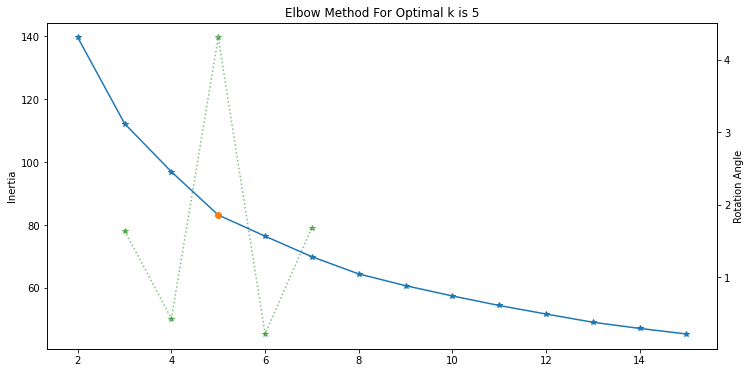

In [23]:
k = cv.elbow_scoring(plot=True)

The optimal cluster number is **2** due to the metric on Silhouette Score.


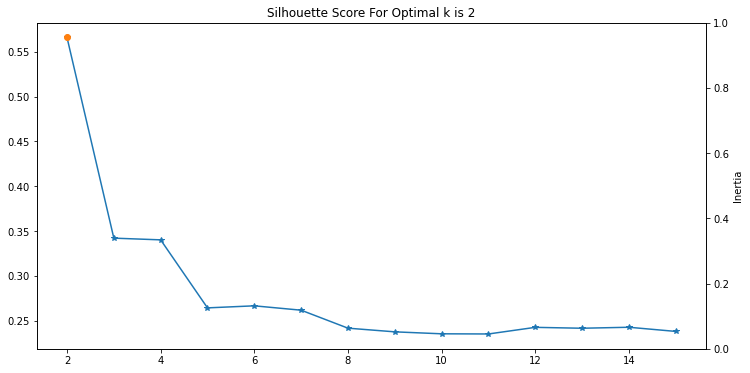

In [24]:
cv.silhouette_scoring(plot=True)

# 7. Choose optimum number of clusters and visualize it using PCA

***

Visualization could help people to understand the homogeneity of K-Means clusters.

As the scatter plot shows in this section: k=2 is the most reasonable. This is an other evidence to enhance our knowledge from Silhouette Score, not elbow plot.

As a conclusion, in my opinion, the optimal k is 2 due to metric of silhouette score, not 5(elbow methor).

***

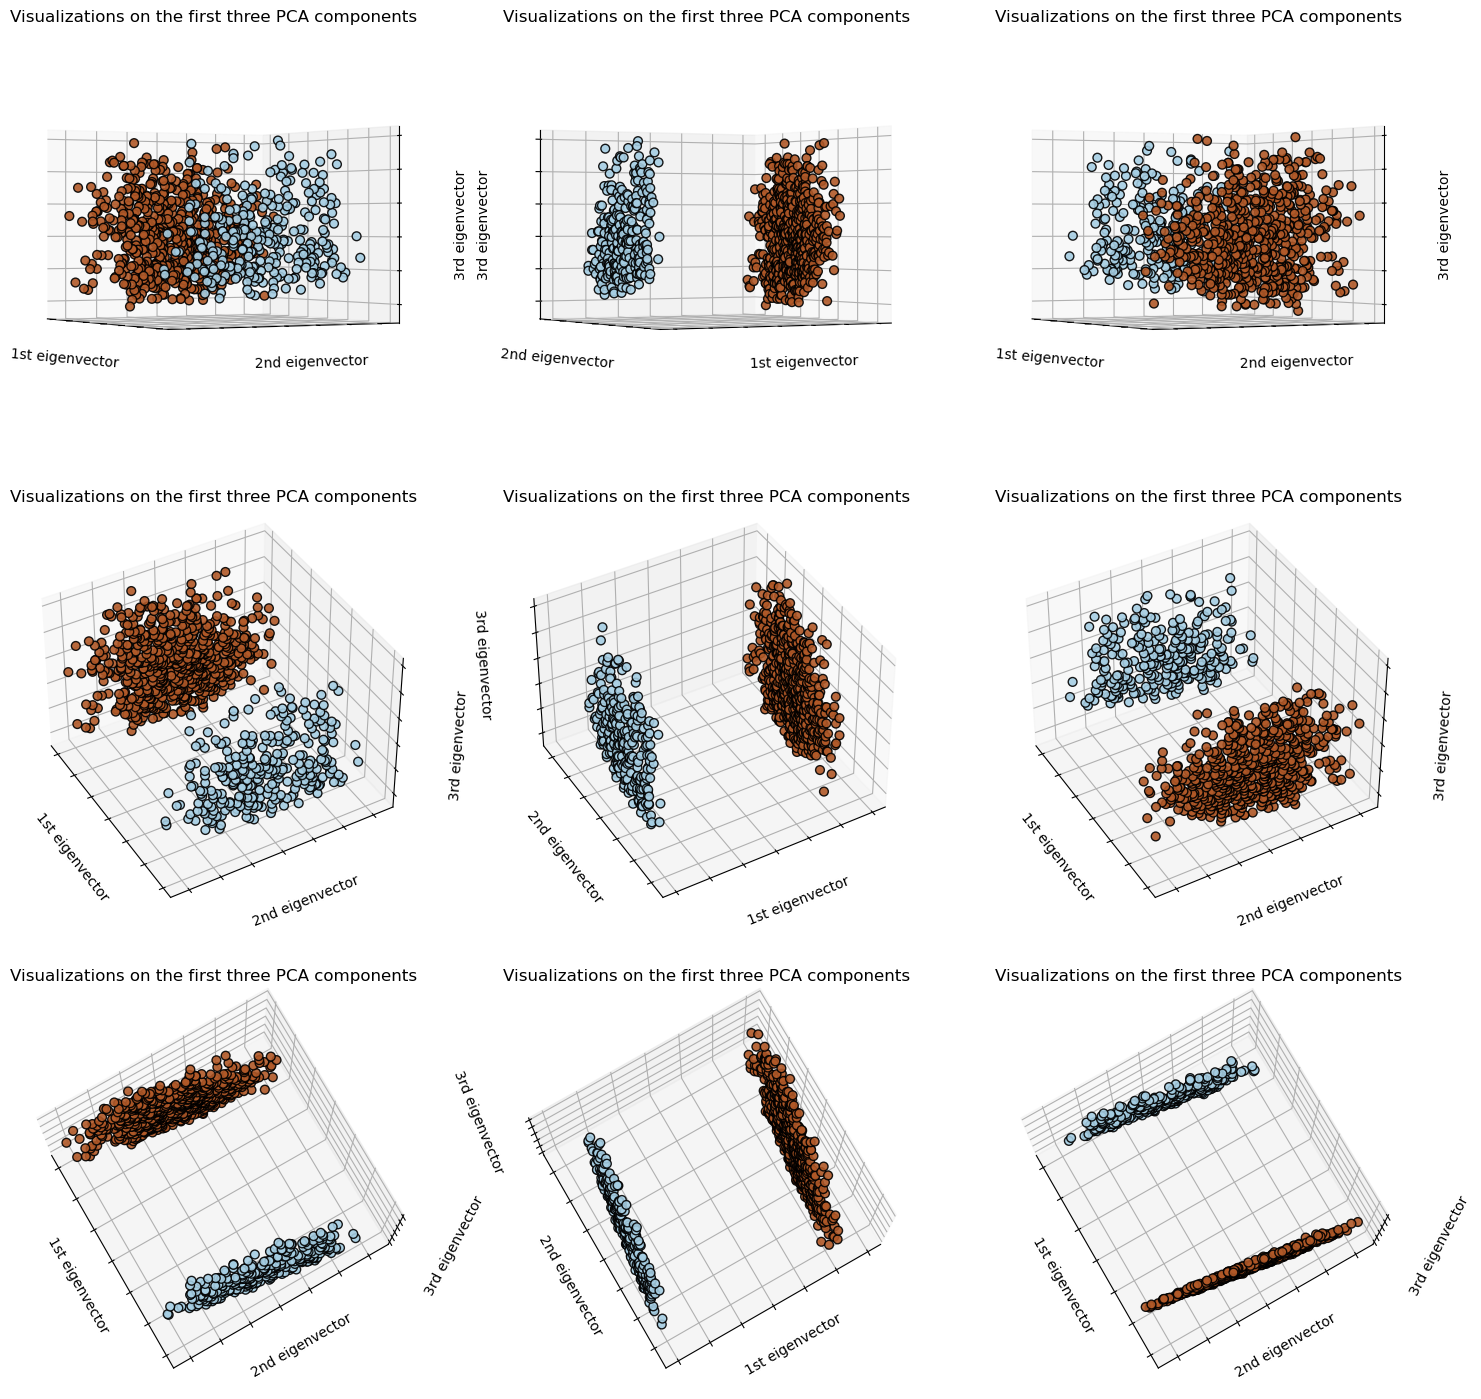

In [25]:
# optimal k=2 by the suggestion of silhouette score
cv.labeling_data(2)
cv.visualize_clusters()

The optimal cluster number is **5** due to the observation on elbow plot.


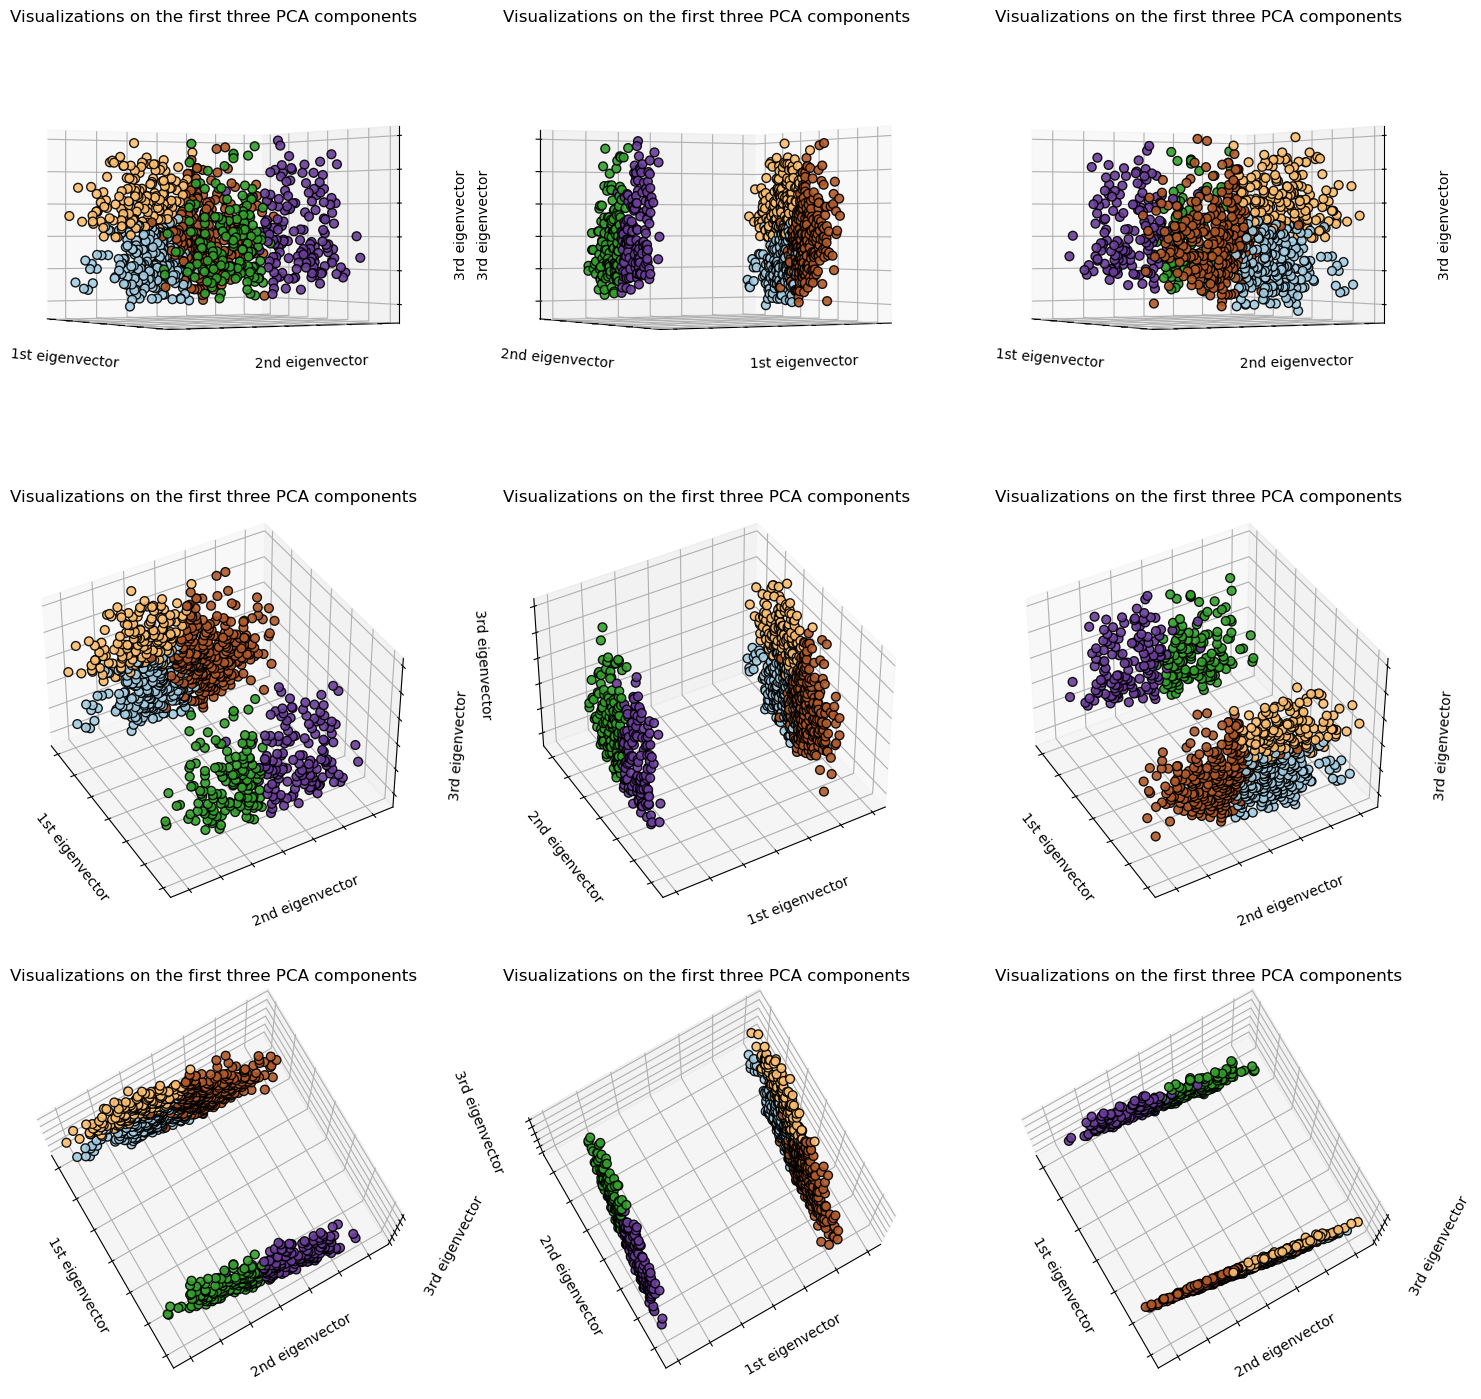

In [26]:
# optimal k=5 by the suggestion of elbow method
print("The optimal cluster number is **%s** due to the observation on elbow plot." % k)
cv.labeling_data(5)
cv.visualize_clusters()

# 8. Implement KFOLD CV and use any classifier of your choosing and report the evaluation metrics

In [27]:
class Driver:
    def __init__(self, testing=False, frac=0.01, test_split_size=0.1):
        self.foo = Foo()
        if testing:
            self.foo.label_encoding()
            self.foo.df = self.foo.df.sample(frac=frac, replace=False, random_state=0)
        r = random.randint(1, 10000)
        print("test site split random_state : %d" % r)
        self.df = self.foo.df
        self.X = self.foo.X
        self.y = self.foo.y
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, test_size=test_split_size, random_state=r, stratify=self.y)
        if not testing:
            self.X_train, self.X_test = self.foo.onehot_encoding(self.X_train, self.X_test)
        print("sample size: %s" % str(self.foo.df.shape))
        print("training data size: %s" % str(self.X_train.shape))
    pass

    def model_select(self, results):
        print("Now the best model is")
        best_model_name = None
        best_accuracy = 0.0
        self.__print_title()
        for _, tup in enumerate(results):
            self.__print_result(tup)
            name = tup[0]
            accuracy = tup[1][2]
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_name = name
        
        algo = best_model_name.split(' ')[0]
        print(
            "%s received the highest average performance with accuracy %.4f. Therefore %s is the most suitable model.\n" % (
            algo, best_accuracy, algo))

    def evaluating(self, callable_, verbose=0):
        self.__print_title()
        buffer = []
        name = None
        # pred_lst = []
        for _ in range(5):
            name, clf = callable_(self.X_train, self.y_train,
                                  random_state=random.randint(1, 10000), verbose=verbose)
            start = time()
            y_pred = clf.predict(self.X_test)
            # pred_lst.append(y_pred)
            cost = (time() - start) * 1000
            # tmp_params = clf.cv_results_['params'][clf.best_index_]
            tup = (
                round(clf.cv_results_['mean_test_score'][clf.best_index_], 3),
                round(clf.cv_results_['std_test_score'][clf.best_index_] * 2, 3),
                round(accuracy_score(self.y_test, y_pred), 3),
                round(precision_score(self.y_test, y_pred, average='macro'), 3),
                round(recall_score(self.y_test, y_pred, average='macro'), 3),
                round(cost, 3),
            )
            buffer.append(np.array(tup))
            self.__print_result((name, tup))
        tup = np.array(buffer).mean(axis=0)
        self.__print_result(("%s avg" % name, tup))
        print()
        # self.df[name] = pd.DataFrame(pred_lst).mode().values.flatten()
        return "%s avg" % name, tup

    @staticmethod
    def __print_title():
        print("%15s\t%10s\t%10s\t%10s\t%10s\t%10s\t%10s" % (
            "model", "mean", "std", "accuracy", "precision", "recall", "latency"))

    @staticmethod
    def __print_result(tup):
        name, r = tup
        if name.find("avg") >= 0:
            std = ""
        else:
            std = "+/-%.3f" % r[1]
        print("%15s\t%10s\t%10s\t%10s\t%10s\t%10s\t%10s" % (
            "%s" % name, "%.3f" % r[0], std, "%.3f" % r[2], "%.3f" % r[3], "%.3f" % r[4], "%.3f ms" % r[5]))

    def evaluating_model(self, clf):
        pred = clf.predict(self.X_test)
        print('Training set score: {:.4f}'.format(clf.score(self.X_train, self.y_train)))
        print('Test set score: {:.4f}'.format(clf.score(self.X_test, self.y_test)))
        print('Model accuracy score: {0:0.4f}'.format(accuracy_score(self.y_test, pred)))
        print(classification_report(self.y_test, pred))
        pass


go = Driver(testing=False, test_split_size=0.1)


test site split random_state : 5864
sample size: (1000, 8)
training data size: (900, 17)


## 8.1. applying training data to classification models

In [29]:
go.X_train.shape
pd.DataFrame(go.X_train)

0    1    2    3    4    5    6         7     8    9    10   11   12   13   14   15   16
0   -0.200000  0.0  0.0 -1.0  0.0  0.0  0.0 -0.105122  0.50  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1    0.533333 -1.0  1.0 -1.0  0.0  0.0  0.0 -0.788508 -1.00  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2   -0.400000  0.0  0.0  0.0  0.0  0.0  0.0  0.062074  0.50  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3    1.133333 -1.0  1.0  0.0 -1.0  1.0  0.0  0.142020  1.50  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4    0.866667  0.0  0.0  0.0  0.0  0.0  0.0 -0.368406 -1.00  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
..        ...  ...  ...  ...  ...  ...  ...       ...   ...  ...  ...  ...  ...  ...  ...  ...  ...
895  1.466667  0.0  0.0  0.0  0.0  0.0  0.0  1.756702  0.50  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
896 -0.533333 -1.0  1.0 -1.0  0.0  0.0  0.0  0.126646 -0.25  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
897 -0.466667  0.0  0.0  0.0  0.0  0.0  0.0 -0.367637  0.00  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
898  0.066667  0.0  0.0 -1.0 -1.0  1.0  0.0  0.592870  2.50  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
899  0.400000  0.0  0.0 -1.0  0.0  0.0  0.0 -0.720861 -1.00  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0

[900 rows x 17 columns]

In [30]:
arr = [
    go.evaluating(go.foo.train_XGB, verbose=0),
    go.evaluating(go.foo.train_RF, verbose=0),
    go.evaluating(go.foo.train_LR, verbose=0),
    go.evaluating(go.foo.train_DT, verbose=0),
    go.evaluating(go.foo.train_NB, verbose=0),
]

          model	      mean	       std	  accuracy	 precision	    recall	   latency
            XGB	     0.713	  +/-0.044	     0.680	     0.556	     0.524	  1.948 ms
            XGB	     0.714	  +/-0.023	     0.680	     0.518	     0.505	  1.612 ms
            XGB	     0.713	  +/-0.024	     0.680	     0.518	     0.505	  1.612 ms
            XGB	     0.709	  +/-0.013	     0.700	     0.350	     0.500	  1.677 ms
            XGB	     0.708	  +/-0.062	     0.700	     0.604	     0.519	  1.668 ms
        XGB avg	     0.711	          	     0.688	     0.509	     0.511	  1.703 ms

          model	      mean	       std	  accuracy	 precision	    recall	   latency
             RF	     0.706	  +/-0.037	     0.670	     0.518	     0.507	 15.866 ms
             RF	     0.713	  +/-0.054	     0.660	     0.500	     0.500	  7.817 ms
             RF	     0.722	  +/-0.033	     0.670	     0.518	     0.507	  4.053 ms
             RF	     0.716	  +/-0.045	     0.690	     0.553	     0.512	  8.251 ms
             RF

## 8.2. Conclusion

LR received the highest average performance with accuracy 0.7000. Therefore LR is the most suitable model.


In [31]:
go.model_select(arr)

Now the best model is
          model	      mean	       std	  accuracy	 precision	    recall	   latency
        XGB avg	     0.711	          	     0.688	     0.509	     0.511	  1.703 ms
         RF avg	     0.714	          	     0.670	     0.512	     0.503	  7.549 ms
         LR avg	     0.713	          	     0.700	     0.604	     0.519	  0.107 ms
         DT avg	     0.703	          	     0.692	     0.567	     0.517	  0.110 ms
         NB avg	     0.660	          	     0.660	     0.568	     0.556	  0.209 ms
LR received the highest average performance with accuracy 0.7000. Therefore LR is the most suitable model.

